# $\textbf{Encryption using Image Segmentation}$

### $\textbf{Tools and Libraries used:}$

- Numpy
- PyTorch
- Matplotlib
- CV2
- PIL
- stegano

### $\textbf{Problem Statement}$

Designing an image encryption and decryption system using panoptic segmentation for securing confidential information. The system involves segmenting the image using panoptic segmentation to identify the target region, encrypting the desired message within the target region, and then creating a new image with the encrypted message. The system should be able to decrypt the message using the same panoptic segmentation process and retrieve the original message. The objective of this project is to develop an efficient and secure method for protecting sensitive information within an image using advanced image segmentation techniques.

In [1]:
from PIL import Image
import matplotlib.image as mt
import matplotlib.pyplot as plt
import numpy as np
import io
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
from torchvision.models import ResNet101_Weights
from collections import defaultdict
import itertools
import seaborn as sns
import cv2

# Libraries for encrypting the data #
!pip install stegano
from stegano import lsb
from stegano.lsb import generators

# To ignore warnings #
import warnings
warnings.filterwarnings("ignore")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# We deal with png images. 

jpg_image = Image.open('img1.jpg')

png_image = jpg_image.convert('RGBA')

png_image.save('img1.png')

In [3]:
## referred this github https://github.com/cocodataset/panopticapi for rgb2id and id2rgb functions.
## The algorithm used for interpolation is determined by mode.
cent = (2,3)
def interpolate(input,size=None,mode="nearest"):
    return nn.functional.interpolate(input,size,scale_factor=None,mode=mode)

def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(-1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=-1)

## generates unique IDs that have meaningful RGB encoding.
## The RGB encoding used is ID = R * 256 * G + 256 * 256 + B.
def rgb2id(color):
    if isinstance(color, np.ndarray) and len(color.shape) == 3:
        if color.dtype == np.uint8:
            color = color.astype(np.int32)
        return color[:, :, 0] + 256 * color[:, :, 1] + 256 * 256 * color[:, :, 2]
    return int(color[0] + 256 * color[1] + 256 * 256 * color[2])
  
## decoding from id to RGB
def id2rgb(id_map):
    if isinstance(id_map, np.ndarray):
        id_map_copy = id_map.copy()
        rgb_shape = tuple(list(id_map.shape) + [3])
        rgb_map = np.zeros(rgb_shape, dtype=np.uint8)
        for i in range(3):
            rgb_map[..., i] = id_map_copy % 256
            id_map_copy //= 256
        return rgb_map
    color = []
    for _ in range(3):
        color.append(id_map % 256)
        id_map //= 256
    return color

In [4]:
## loading pretrained DETR model from torch hub
model = torch.hub.load('facebookresearch/detr','detr_resnet101_panoptic',pretrained=True,num_classes=250)
model.eval()

Using cache found in /root/.cache/torch/hub/facebookresearch_detr_main


DETRsegm(
  (detr): DETR(
    (transformer): Transformer(
      (encoder): TransformerEncoder(
        (layers): ModuleList(
          (0-5): 6 x TransformerEncoderLayer(
            (self_attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
            )
            (linear1): Linear(in_features=256, out_features=2048, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
            (linear2): Linear(in_features=2048, out_features=256, bias=True)
            (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
            (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
            (dropout1): Dropout(p=0.1, inplace=False)
            (dropout2): Dropout(p=0.1, inplace=False)
          )
        )
      )
      (decoder): TransformerDecoder(
        (layers): ModuleList(
          (0-5): 6 x TransformerDecoderLayer(
            (self_attn): MultiheadAttention(
             

In [5]:
## Referred this github https://github.com/facebookresearch/detr
class PostProcessPanoptic(nn.Module):
    """This class converts the output of the model to the final panoptic result, in the format expected by the
    coco panoptic API"""
    def __init__(self, is_thing_map, threshold=0.85):
        """
        Parameters:
           is_thing_map: This is a whose keys are the class ids, and the values a boolean indicating whether
                          the class is  a thing (True) or a stuff (False) class
           threshold: confidence threshold: segments with confidence lower than this will be deleted
        """
        super().__init__()
        self.threshold = threshold
        self.is_thing_map = is_thing_map

    def forward(self, outputs, processed_sizes, target_sizes=None):
        """ This function computes the panoptic prediction from the model's predictions.
        Parameters:
            outputs: This is a dict coming directly from the model. See the model doc for the content.
            processed_sizes: This is a list of tuples (or torch tensors) of sizes of the images that were passed to the
                             model, ie the size after data augmentation but before batching.
            target_sizes: This is a list of tuples (or torch tensors) corresponding to the requested final size
                          of each prediction. If left to None, it will default to the processed_sizes
        """
        if target_sizes is None:
            target_sizes = processed_sizes
        assert len(processed_sizes) == len(target_sizes)
        out_logits, raw_masks, raw_boxes = outputs["pred_logits"], outputs["pred_masks"], outputs["pred_boxes"]
        assert len(out_logits) == len(raw_masks) == len(target_sizes)
        preds = []

        def to_tuple(tup):
            if isinstance(tup, tuple):
                return tup
            return tuple(tup.cpu().tolist())

        for cur_logits, cur_masks, cur_boxes, size, target_size in zip(
            out_logits, raw_masks, raw_boxes, processed_sizes, target_sizes
        ):
            # we filter empty queries and detection below threshold
            scores, labels = cur_logits.softmax(-1).max(-1)
            keep = labels.ne(outputs["pred_logits"].shape[-1] - 1) & (scores > self.threshold)
            cur_scores, cur_classes = cur_logits.softmax(-1).max(-1)
            cur_scores = cur_scores[keep]
            cur_classes = cur_classes[keep]
            cur_masks = cur_masks[keep]
            cur_masks = interpolate(cur_masks[:, None], to_tuple(size), mode="bilinear").squeeze(1)
            cur_boxes = box_cxcywh_to_xyxy(cur_boxes[keep])

            h, w = cur_masks.shape[-2:]
            assert len(cur_boxes) == len(cur_classes)

            # It may be that we have several predicted masks for the same stuff class.
            # In the following, we track the list of masks ids for each stuff class (they are merged later on)
            cur_masks = cur_masks.flatten(1)
            stuff_equiv_classes = defaultdict(lambda: [])
            for k, label in enumerate(cur_classes):
                if not self.is_thing_map[label.item()]:
                    stuff_equiv_classes[label.item()].append(k)

            def get_ids_area(masks, scores, dedup=False):
                # This helper function creates the final panoptic segmentation image
                # It also returns the area of the masks that appears on the image

                m_id = masks.transpose(0, 1).softmax(-1)

                if m_id.shape[-1] == 0:
                    # We didn't detect any mask :(
                    m_id = torch.zeros((h, w), dtype=torch.long, device=m_id.device)
                else:
                    m_id = m_id.argmax(-1).view(h, w)

                if dedup:
                    # Merge the masks corresponding to the same stuff class
                    for equiv in stuff_equiv_classes.values():
                        if len(equiv) > 1:
                            for eq_id in equiv:
                                m_id.masked_fill_(m_id.eq(eq_id), equiv[0])

                final_h, final_w = to_tuple(target_size)

                seg_img = Image.fromarray(id2rgb(m_id.view(h, w).cpu().numpy()))
                seg_img = seg_img.resize(size=(final_w, final_h), resample=Image.NEAREST)

                np_seg_img = (
                    torch.ByteTensor(torch.ByteStorage.from_buffer(seg_img.tobytes())).view(final_h, final_w, 3).numpy()
                )
                m_id = torch.from_numpy(rgb2id(np_seg_img))

                area = []
                for i in range(len(scores)):
                    area.append(m_id.eq(i).sum().item())
                return area, seg_img

            area, seg_img = get_ids_area(cur_masks, cur_scores, dedup=True)
            if cur_classes.numel() > 0:
                # We know filter empty masks as long as we find some
                while True:
                    filtered_small = torch.as_tensor(
                        [area[i] <= 4 for i, c in enumerate(cur_classes)], dtype=torch.bool, device=keep.device
                    )
                    if filtered_small.any().item():
                        cur_scores = cur_scores[~filtered_small]
                        cur_classes = cur_classes[~filtered_small]
                        cur_masks = cur_masks[~filtered_small]
                        area, seg_img = get_ids_area(cur_masks, cur_scores)
                    else:
                        break

            else:
                cur_classes = torch.ones(1, dtype=torch.long, device=cur_classes.device)

            segments_info = []
            for i, a in enumerate(area):
                cat = cur_classes[i].item()
                segments_info.append({"id": i, "isthing": self.is_thing_map[cat], "category_id": cat, "area": a})
            del cur_classes

            with io.BytesIO() as out:
                seg_img.save(out, format="PNG")
                predictions = {"png_string": out.getvalue(), "segments_info": segments_info}
            preds.append(predictions)
        return preds

In [6]:
# Function which is used to segment the image #
def segmentImage(img_path):
  im = plt.imread(img_path)
  ## standard PyTorch mean-std input image normalization
  transform = T.Compose([
      T.Resize(im.shape[0]),
      T.ToTensor(),
      T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ])
  img = transform(Image.fromarray(im)).unsqueeze(0)
  out = model(img)  
  is_thing_map = {i: i <= 90 for i in range(250)}
  pp = PostProcessPanoptic(is_thing_map)
  result = pp.forward(out, torch.as_tensor(img.shape[-2:]).unsqueeze(0))[0]
  # The segmentation is stored in a special-format png
  panoptic_seg = Image.open(io.BytesIO(result['png_string']))
  panoptic_seg = np.array(panoptic_seg, dtype=np.uint8).copy()
  # We retrieve the ids corresponding to each mask
  panoptic_seg_id = rgb2id(panoptic_seg)
  palette = itertools.cycle(sns.color_palette())
  # panoptic_seg = np.zeros(im.shape)
  panoptic_seg[:, :, :] = 0
  for id in range(panoptic_seg_id.max() + 1):
    if id == 2:
      panoptic_seg[panoptic_seg_id == id] = np.asarray(next(palette)) * 255
  mt.imsave("targetted_segment.png",panoptic_seg)
  panoptic_seg[:, :, :] = 0
  for id in range(panoptic_seg_id.max() + 1):
      panoptic_seg[panoptic_seg_id == id] = np.asarray(next(palette)) * 255
  mt.imsave("segmented_image.png",panoptic_seg)
  return panoptic_seg_id

In [7]:
## Encoder function
def encode(img_path,msg):
  ## segment the image
  im = plt.imread(img_path)
  seg_id = segmentImage(img_path)
  ## find encrypt space
  idx = np.where(seg_id==2) # indices in the image where id==2, idx is a tuple of arrays, i.e (idx[0][3],idx[1][3]) is one of the location where id==2
  global cent 
  cent = int(idx[0].mean()),int(idx[1].mean()) # centroid location
  s = 50 ## parameter of size of the encryptrd image 
  png = plt.imread('img1.png')
  encrypt_space = png[cent[0]-s:cent[0]+s,cent[1]-s:cent[1]+s,:]
  ## encrypt the msg in the above space
  mt.imsave('en_sp.png',encrypt_space)
  image_path = "en_sp.png"
  secret_image = lsb.hide(image_path, msg, generators.eratosthenes()) # Encode the message in the image using LSB steganography 
  secret_image.save("secret.png") # Save the encoded image
  ## return the whole image
  encrypt_image = png.copy()
  encrypt_image[cent[0]-s:cent[0]+s,cent[1]-s:cent[1]+s,:] = encrypt_space
  mt.imsave('encrypt_image.png',encrypt_image)
  return encrypt_image

In [8]:
# Encrpyting the message #
message = "\n Team Members:\n Adarsh Sai Adepu \n Savarana Datta Reddy \n Rahul Naga \n Dhatri Nanda"
enc_img = encode('img1.jpg',message)

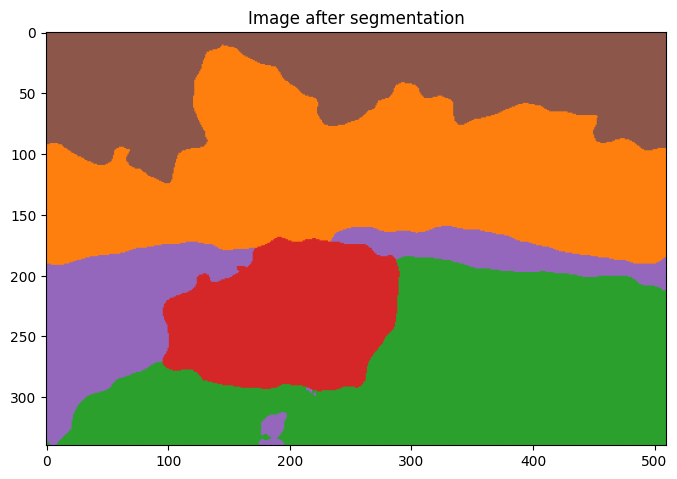

In [9]:
plt.figure(figsize=(8,8))
a = plt.imread('segmented_image.png')
plt.imshow(a)
plt.title("Image after segmentation")
plt.show()

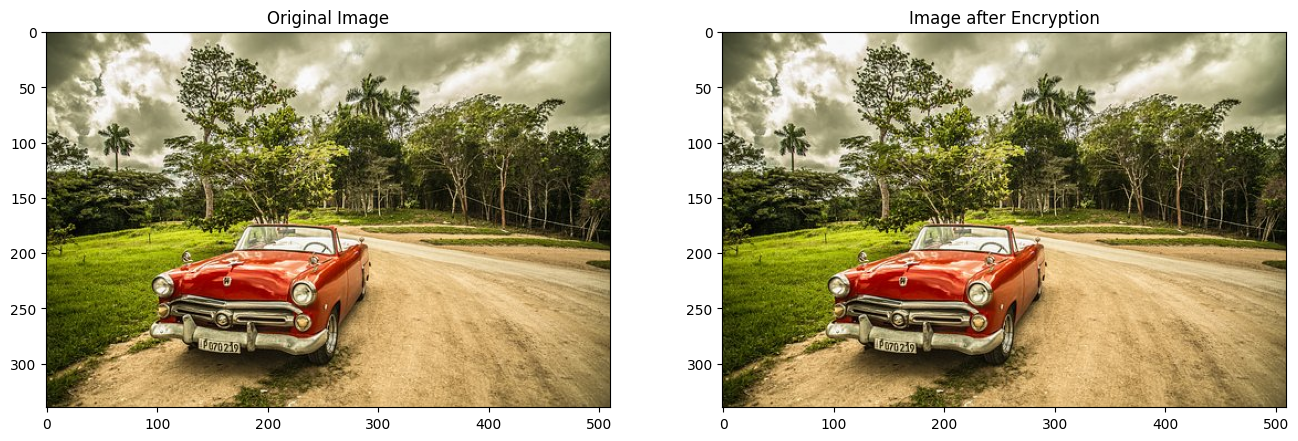

In [10]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
a = plt.imread('img1.jpg')
plt.imshow(a)
plt.title('Original Image')

plt.subplot(1,2,2)
a = plt.imread('encrypt_image.png')
plt.imshow(a)
plt.title('Image after Encryption')
plt.show()

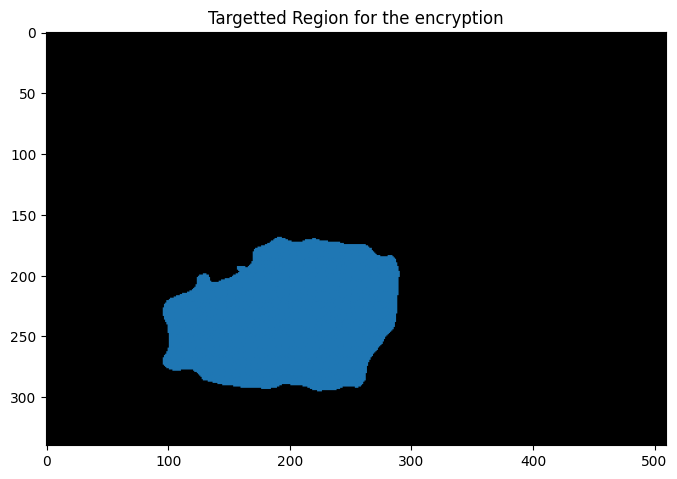

In [11]:
plt.figure(figsize=(8,8))
a = plt.imread('targetted_segment.png')
plt.imshow(a)
plt.title("Targetted Region for the encryption")
plt.show()

In [12]:
def decoder_helper(enc_img_path):
  img = plt.imread(enc_img_path)
  seg_id = segmentImage(enc_img_path)
  idx = np.where(seg_id==2)
  cent = int(idx[0].mean()),int(idx[1].mean())
  return cent

In [13]:
# Decoder Function #
def decode(enc_img_path):
  enc_img = plt.imread(enc_img_path)
  s = 50 ## parameter of size of the encrypted image 
  png_img = cv2.imread(enc_img_path)
  t = 'enc_img_path.jpg'
  cv2.imwrite(t, png_img, [int(cv2.IMWRITE_JPEG_QUALITY), 100])
  cent_ = decoder_helper(t)
  encrypt_space = enc_img[cent[0]-s:cent[0]+s,cent[1]-s:cent[1]+s,:]
  x = plt.imread("secret.png")
  mt.imsave('en_sp_decript.png',encrypt_space)
  decoded_message = lsb.reveal("secret.png", generators.eratosthenes()) 
  return decoded_message

In [14]:
message = decode('encrypt_image.png')
print("Message: \n", message)

Message: 
 
 Team Members:
 Adarsh Sai Adepu 
 Savarana Datta Reddy 
 Rahul Naga 
 Dhatri Nanda


### $\textbf{Now let us encrypt an image instead of a string}$

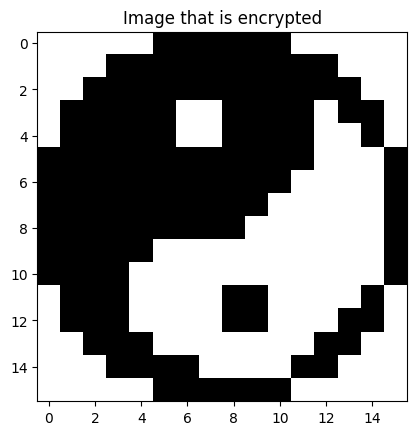

In [15]:
x= np.load('image.npy')
plt.imshow(x,cmap='gray')
plt.title("Image that is encrypted")
x = np.array(x)
x = x.reshape(-1)
x = ''.join(str(i) for i in x)

In [16]:
enc_im = encode('img1.jpg',x)

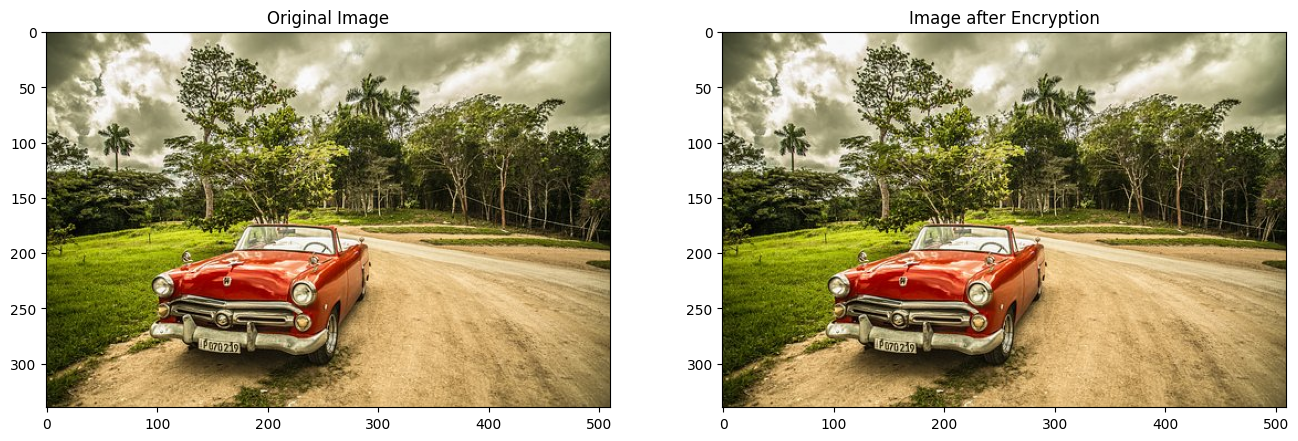

In [17]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
a = plt.imread('img1.jpg')
plt.imshow(a)
plt.title('Original Image')

plt.subplot(1,2,2)
a = plt.imread('encrypt_image.png')
plt.imshow(a)
plt.title('Image after Encryption')
plt.show()

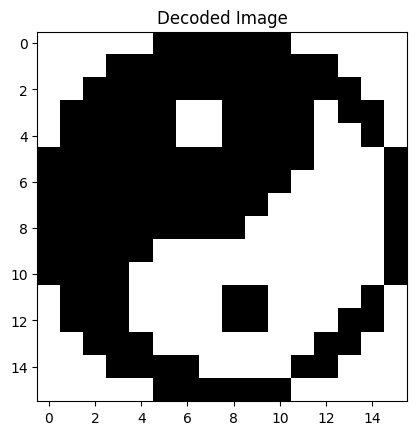

In [18]:
t = decode('encrypt_image.png')
op = np.zeros((16,16))
for i in range(16):
  for j in range(16):
    op[i][j] = int(t[(16*i)+j])
plt.imshow(op,cmap='gray')
plt.title("Decoded Image")
warnings.filterwarnings("default")

### $\textbf{References}$
- $\href{https://github.com/cocodataset/panopticapi}{\text{Panoptic Segmentation GitHub}}$
- $\href{https://github.com/facebookresearch/detr}{\text{DETR GitHub}}$